Initialization:

In [149]:
%reload_ext snakeviz
%matplotlib inline
%run SBRG.py

#Core Code

## Pauli Algebra
- Each Pauli monomial (call a `term`) is represented as a list like `[mat, val]`, where
  - `mat` is a dict recording the Pauli matrix indices in the sparse form, as `{3: 1, 5: 2, ..}` 
  - `val` is a **real** number recording the coefficient of that term.
     - We will only deal with real coefficient now! Because Hamiltonian is Hermitian, and the unitary gates can be represented by their generators which are also Hermitian.
- Each Pauli polynomial is stored as a list of Pauli monomials.

###Dot Product
- Single-bit dot product rule is stored in a dict `DOT_RULES`, each entry is  like `(i,j): (k,n)` formulating $\sigma^i\sigma^j=\text{i}^n\sigma^k$ (where $n=0,\pm1$ is the power of $\text{i}$).
- Multi-bit dot product is carried out by mapping the `DOT_RULES` to the pair of Pauli indices, and collect the resulting indices and powers. The posers are sum together to obtain the finnal power.
- `dot(term1, term2, n0 = 0)` dot product of two terms. The optional `n0` gives the addtional powers of $\text{i}$ to be timed, the result will be: $$\text{i}^{n_0}h_{[\mu]_1}h_{[\mu]_2}\sigma^{[\mu]_1}\sigma^{[\mu]_2}$$
   - subroutine `merge(mat1_get, mat2_get, mat1_keys, mat2_keys)` merges two dicts `mat1` and `mat2` (providing the get method and the keys), missing keys are treated by 0 value. This creates a list of non-trivial pair of Pauli indices `merged = [[i, mu1, mu2], ...]` where `i` index the qubit position and `mu1`, `mu2` are Pauli indices to be dotted.
   - subroutine `dotover(merged)` transform every element `[i, mu1, mu2]` in `merged` to `[i, mu, n]` by applying the DOT_RULES
   - `powofi(merged, n0)` calculate the power of $\text{i}$ (mod 4) from the dotted `merged` given the shift of `n0`.
   - `newmat(merged)` construct new matrix dict from the dotted `merged`.

In [2]:
a1 = [{0: 2, 1: 2, 2: 3}, 0.06389459153589115]
a2 = [{0: 1, 1: 1, 3: 3}, -0.030666385691511793]
dot(a1, a2)

[{0: 3, 1: 3, 2: 3, 3: 3}, 0.001959416187641243]

###Find Rotation to Diagonalize Pauli Matrix
**Goal**: rotate $\sigma^{[0|3..][\mu]}$ to the block diagonal form $\sigma^{[0..]3[0..]}$ with 3 at the intent position, and the transformation must respect all the $\sigma^3$ symmetries before the intent position.

**Algorithm**:
- If $[\mu]$ contains 1|2 (once the first 1|2 found, break): rotate that bit to 3 while eliminating other bits to 0 by `C4`, and move 3 to the the intent position by `SWAP` if necessary.
- Elseif $[\mu]$ has no 1|2 but 3 exist:
  - If there are multiple 3's (*for the whole indices*): need two `C4` rotations
    - If there is a 3 at the intent position: do the double-`C4` at that position, and no `SWAP` needed.
    - Elseif the intent position is 0: do the double-`C4` at the position of the last 3, followed by `SWAP`.
  - Elseif there is only one 3: just do a `SWAP` (if 3 sits at intent position, no transformation needed).
- Else $[\mu]$ is $[0..]$: no transform needed (but such matrixes should have already been ascribed to the conserved quantity and should not appear).

In [3]:
find_rotation({0: 1, 5: 3}, 0)

[['C4', [{0: 2, 5: 3}, -1.0]]]

The result of `find_rotation` is a list of unitary transformations: each element is of the following form:
- `['C4',[{...},z]]`: C4 rotation with C4 generator.
- `['SWAP',[i, j]]`: SWAP operation btw i & j bit.

The unitary transformations are implemented by
- `unitary_fd(Us, H)`: forward transfrom from boundary to bulk,
- `unitary_bk(Us, H)`: backward transform from bulk to boundary (`Us` still given by the forward order),
where `Us` is a list of transformations (action implemented in sequencial order), and `H` is the Pauli polynomial (or a list of Pauli monomials) to be acted.

In [4]:
H = [[{0: 3, 5: 3, 7: 3}, 1], [{0: 3, 5: 2, 7: 1}, 1]]
Us = find_rotation(H[0][0],0)
print(Us)
unitary_fd(Us,H)
H

[['C4', [{0: 2, 5: 3, 7: 3}, 1.0]], ['C4', [{0: 2}, -1]]]


[[{0: 3}, 1.0], [{0: 3, 5: 1, 7: 2}, 1.0]]

In [5]:
unitary_bk(Us, H)
H

[[{0: 3, 5: 3, 7: 3}, 1.0], [{0: 3, 5: 2, 7: 1}, 1.0]]

###Compute and Control 2nd Order Perturbation
Given the off-diagonal terms $\Sigma_0=\sum_{[\mu]}h_{[\mu]}\sigma^{[\mu]}$ and $H_0=h_0\sigma^{3[0..]}$, the 2nd order perturbation is then given by:
$$\begin{split}
H_2 &= \frac{1}{2h_0^2} H_0\Sigma_0^2 = \frac{1}{2h_0} \sigma^{3[0..]}\Sigma_0^2\\
&=\Big(\frac{1}{2h_0}\sum_{[\mu]}h_{[\mu]}^2\Big)\sigma^{3[0..]}+ \sum_{[\mu]_1<[\mu]_2}\frac{h_{[\mu]_1}h_{[\mu]_2}}{h_0}\;\sigma^{3[0..]}\,\Re[\sigma^{[\mu]_1}\sigma^{[\mu]_2}].
\end{split}$$
- the first term is a backward correction to the leading energy scale,
- the second term generates new terms and should be controlled,
- $\Re$ of Pauli matrices is non-vanishing only of the matrices commute.

The growth the Hamiltonian is controlled by:
- energy scale truncation `min_scale`: terms with energy scale less then `min_scale` will be neglected,
- term number truncation `max_rate`: the perturbed H contains at most `max_rate`$\times$ number of $H_\text{offdiag}$ terms.

##Spectrum Bifurcation RG
Generic Hamiltonian: qubit models
$$H=\sum_{[\mu]}h_{[\mu]}\sigma^{[\mu]},$$
where $\sigma^{[\mu]}=\sigma^{\mu_1}\otimes\sigma^{\mu_2}\otimes\sigma^{\mu_3}\otimes\cdots$ denotes the product of Pauli matrices (quantum gates). The key assumption is $h_{[\mu]}$ should be sufficiently random.

###RG Kernel
**Algorithm**:
- Find leading energy scale
- Find Clifford algebra rotation $R$ that
  - diagonalize the leading energy scale
  - at the same time transform the other terms in the Hamiltonian (note that the term ordering is lost in this step)
- Gather diagonal and off-diagonal terms
    $$H = H_0 + \Delta_0 + \Sigma_0$$
   where $H_0^2 = h_0^2$, $H_0\Delta_0 = \Delta_0H_0$, $H_0\Sigma_0 = -\Sigma_0H_0$.
  - diagonal terms goes to new Hamiltonian
  - off-diagonal terms renormalized by 2nd order perturbation, which generates effective terms in the diagonal blocks.[1]
    $$H = H_0 + \Delta_0 + \frac{1}{2h_0^2} H_0\Sigma_0^2.$$
    The perturbation can be carried out by the unitary transform
    $$U = \exp\left(-\frac{1}{2h_0^2}H_0\Sigma_0\right).$$

###Restore Locality
- Clifford gates are collected in forward order along the RG flow. At the end of the flow, `self.gates` will hold the Clifford gates $R = R_\text{C4}R_\text{SWAP}R_\text{C4}R_\text{C4}R_\text{SWAP}R_\text{SWAP}\cdots$
- The emergent qubits are arranged by their *energy scale*: first/last bit - heighest/lowest frequency. Such arrangement is good to improve the computational efficiency during the RG flow, but the *realspace position* of these emergent qubits are scrambled, and the original locality is lost.
- To restore the original locality,
  - first move all the SWAP gates to the end by commuting over the C4 gates.
    $$ \text{physical} \xrightarrow{C_4} \text{emergent (ordered by realspace location)} \xrightarrow{SWAP} \text{emergent (ordered by energy scale)}$$
  - then absorb SWAP gates to `Heff` by backward action. In this way, the locality is mostly restored (at least localized to each entanglement block).
  
**Algorithm**: reorder the matrix indices in `Heff`
- starting from a ordered list of inds: `blk = [0,1,2...]` the elements labels the qubit positions of energy-scale-ordered Hilbert space. 
- apply SWAP in backward order to the list, permutes the energy-scale labels to the real-space positions.
- so the mat ind of `Heff` must be brought back to real-sapce by the value-to-index mapping of `blk`.

###Test

In [134]:
model = TFIsing(128, J=1,K=1,h=0,alpha_J=0.1)

In [135]:
system = SBRG(model)
system.max_rate = 2.
system.make_Hblk = False
system.flow()
len(system.trash)

0

In [136]:
[mat for mat, val in system.taus if mat_span(mat, 128)%2 == 0]

[{36: 3}]

Profiling:

In [19]:
system = SBRG(model)
system.make_Hblk = False
% snakeviz system.flow()

 
*** Profile stats marshalled to file '/var/folders/tl/lwpcq5qj049ftcj7pvhkzv_h0000gn/T/tmp7idjtn'. 


Benchmark with Mathematica:

In [7]:
model = TFIsing(16, J=1,K=1,h=1,alpha_J=0.2,alpha_K=0.2,alpha_h=0.2)
export('model', model)
system = SBRG(model)
system.tol = 1.e-8
system.max_rate = 2.
system.recover = False
system.flow()
export('Heff',system.Heff)
system.trash

[]

##Model Hamiltonians
###Transverse Field Ising with Interaction
For random $J_i$, $K_i$, $h_i$ drawn from a beta distribution,
$$H=-\sum_{i}J_i \sigma_i^x\sigma_{i+1}^x+K_i \sigma_i^z\sigma_{i+1}^z+h_i \sigma_i^z.$$

###Kitaev Random Interaction Model
For random $J_{ijkl}$ drawn from a beta distribution,
$$H=\sum J_{ijkl}\chi_i\chi_j\chi_k\chi_l.$$

In [50]:
random.seed(1)
system = SBRG(KitaevRIM(7,1.))
system.max_rate = 80.
system.flow()
print(len(system.trash))
export('system_KRIM_7', system)

210946


2nd version: control the number of terms.
- L9M9: 1,2,3,5,14,18

In [250]:
random.seed() 
system = SBRG(KitaevRIM2(9,9))
system.max_rate = 100.
system.flow()
print(len(system.trash),len(system.Heff))

0 10


####Level Statistics
Try to do level statistics by scipy sparse array. Turns out to be too slow.

In [28]:
model = KitaevRIM(9,1.)

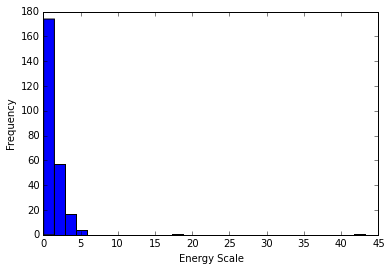

In [30]:
from scipy import sparse, linalg
PAULI = {
    0: sparse.coo_matrix(np.array([[1+0j,0],[0,1+0j]])),
    1: sparse.coo_matrix(np.array([[0,1+0j],[1+0j,0]])),
    2: sparse.coo_matrix(np.array([[0,-1j],[1j,0]])),
    3: sparse.coo_matrix(np.array([[1+0j,0],[0,-1+0j]])),
}
def represent(mat, N):
    A = sparse.identity(1)
    for i in range(N):
        mu = mat.get(i,0)
        A = sparse.kron(A, PAULI[mu],format='coo')
    return A.asformat('csr')
def levstat(H, N):
    Hmat = sum(represent(mat, N)*val for mat, val in H).toarray()
    vals = linalg.eigh(Hmat,eigvals_only=True,turbo=True,overwrite_a=True,check_finite=False)
    diff = [x for x in np.ediff1d(vals) if abs(x)>1e-10]
    return [x/y for x, y in zip(diff[:-1],diff[1:])]
hist_plot(levstat(model['H'], model['bits']))

#Physics
##Level Statistics
###Flow of Energy Scale Distribution

In [407]:
realization = 100
alpha = 1.0
N0 = 128
steps = [0, 32, 32, 32, 16, 8, 4]
data = {}
N = N0
for stp in steps:
    N -= stp
    data[N] = []
for i in range(realization):
    model = TFIsing(N0, J=1,K=0,h=1,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
    system = SBRG(model)
    for stp in steps:
        system.flow(stp)
        data[system.N - system.Neff].extend([abs(val) for (mat, val) in system.H])
export('RGflow_J1K0h1_a10_128', data)

In [428]:
realization = 100
alpha = 1.0
N0 = 256
steps = [0, 64, 32, 32, 32, 32, 16, 16, 16, 8, 4]
data = {}
N = N0
for stp in steps:
    N -= stp
    data[N] = []
for i in range(realization):
    model = TFIsing(N0, J=1,K=1,h=1,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
    system = SBRG(model)
    for stp in steps:
        system.flow(stp)
        data[system.N - system.Neff].extend([abs(val) for (mat, val) in system.H])
export('RGflow_J1K1h1_a10_256', data)

In [154]:
realization = 10
alpha = 1.0
N0 = 6
steps = [0]+[1]*N0
data = {}
N = N0
for stp in steps:
    N -= stp
    data[N] = []
for i in range(realization):
    model = KitaevRIM(N0, alpha)
    system = SBRG(model)
    system.max_rate = 100
    for stp in steps:
        system.flow(stp)
        data[system.N - system.Neff].extend([abs(val) for (mat, val) in system.H])
export('RGflow_KRIM_a10_6x10', data)

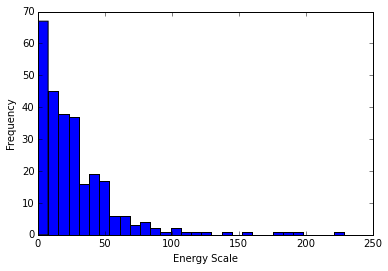

In [161]:
hist_plot(data[2])

###E-Tensor Distribution

**MAKE SURE**: Data collected with back correction turned off.

In [9]:
alpha = 0.2
realization = 200
ns = list(range(1,11))
data = {n: [] for n in ns}
for i in range(realization):
    model = TFIsing(128, J=2,K=1,h=1,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
    system = SBRG(model)
    system.max_rate = 2.2
    system.recover = False
    system.flow()
    for n in ns:
        data[n].extend([abs(val) for [mat, val] in system.Heff if len(mat) == n])
export('Estat_J2K1h1_a02_on', data)

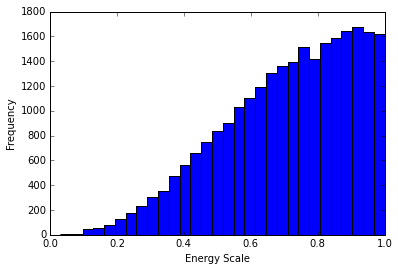

In [362]:
hist_plot(data[1])

###Energy Fluctuation

In [220]:
gs = list(range(1,11))
N = 64
data = {g:[] for g in gs}
for g in gs:
    alpha = 1/g
    dat_append = data[g].append
    for sample in range(100):
        model = TFIsing(N,J=1,K=1,h=0,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
        system = SBRG(model).flow()
        H = deepcopy(model['H'])
        unitary_fd(list(chain(*system.gates)),H)
        var = sum(val**2 for mat, val in H if is_offdiag(mat))
        H2 = sum(val**2 for mat, val in H)
        dat_append(var/H2)
export('EF_J1K1h0_64', data)

##Random Clifford Circuit
###Conserved Quantity
Reconstruct emergent conserved quantities in terms of the original qubits.

In [500]:
system.taus

[[{0: 3, 1: 3}, 1.4031374931022293],
 [{0: 1, 1: 1}, 1.3741709595450602],
 [{2: 3, 3: 3}, 0.8105557290831793],
 [{2: 1, 3: 1}, 0.7097392394612708]]

Collect the statistics of stabilizers.
- Sdat: by number of qubits involved

In [557]:
J0 = 2
K0 = 1
h0 = 1
alpha = 1.0
fn = 'Sdat_J2K1h1_a10_128'
L = 128
try:
    data = load(fn)
except:
    data = {l:[] for l in range(1,L+1)}
for i in range(500):
    model = TFIsing(L,J=J0,K=K0,h=h0,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
    system = SBRG(model)
    system.max_rate = 1.2
    system.flow()
    for [mat, val] in system.taus:
        data[len(mat)].append(abs(val))
dump(fn, data)
export(fn, data)

- Sstat: by head to tail distance of stablizer.

In [151]:
J0 = 7
K0 = 5
h0 = 1
alpha = 1.0
fn = 'Sstat_J7K5h1_a10_128'
L = 128
try:
    data = load(fn)
except:
    data = {l:0 for l in range(L)}
for i in range(0):
    print(i)
    model = TFIsing(L,J=J0,K=K0,h=h0,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
    system = SBRG(model)
    system.make_Hblk = False
    system.flow()
    for [mat, val] in system.taus:
        data[mat_span(mat, L)] += 1
dump(fn, data)
export(fn, data)

In [141]:
dump(fn, data)
export(fn, data)

In [88]:
mat_span({2:1,4:1,1:1},8)

3

###Stablizer State and Entanglement Entropy

test:

In [72]:
alpha = 1.
model = TFIsing(8, J=1.,K=0.,h=0.1,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha)
system = SBRG(model).flow()
export('system_8', system)

In [70]:
system.entropy([3,4,5])

1.0

In [51]:
N = system.N
entropy_dict = entropy1D(system)
{L: sum(entropy_dict.get((i, L), 0) for i in range(N))/N for L in range(1, floor(N/2)+1)}

{1: 0.5, 2: 0.625, 3: 0.75, 4: 0.75}

Collect the entanglement entropy scaling for severl TFIsing samples. Return data as a dict `{L:[S1, S2, ...], ...}`, where `L` is the size of the entanglement cut (in terms of the number of sites in the subsystem), and `S1,...` is a list of disorder-averaged entanglement entropy for different samples. 

In [2]:
def entropy_scaling(N,**para):
    data = {L: [] for L in range(1, floor(N/2)+1)}
    for sample in range(para['sampling']):
        model = TFIsing(N,**para)
        system = SBRG(model).flow()
        entropy_dict = entropy1D(system)
        for L in data.keys():
            data[L].append(sum(entropy_dict.get((i, L), 0) for i in range(N))/N)
    return data

In [16]:
%snakeviz entropy_scaling(128,J=1.,K=0.2,h=0.5,alpha_J=0.5,alpha_K=0.5,alpha_h=0.5,sampling=1)

 
*** Profile stats marshalled to file '/var/folders/tl/lwpcq5qj049ftcj7pvhkzv_h0000gn/T/tmpu5v__p'. 


Export data for Mathematica.

In [3]:
alpha = 1.0
data = entropy_scaling(256,J=6.,K=4.,h=1.,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha,sampling=50)
export('EE_J6K4h1_a10_256x50', data)

In [4]:
alpha = 1.0
data = entropy_scaling(256,J=17,K=14,h=1,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha,sampling=50)
export('EE_J17K14h1_a10_256x50', data)

In [60]:
alpha = 1.0
data = entropy_scaling(256,J=1.,K=1.,h=1.,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha,sampling=50)
export('EE_J1K1h1_a10_256x50', data)

In [56]:
alpha = 0.5
data = entropy_scaling(256,J=1.,K=0,h=0,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha,sampling=50)
export('EE_J1K0h0_a05_256x50', data)

In [57]:
alpha = 0.5
data = entropy_scaling(256,J=0,K=0,h=1.,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha,sampling=50)
export('EE_J0K0h1_a05_256x50', data)

In [58]:
alpha = 0.5
data = entropy_scaling(256,J=0.,K=1.,h=1.,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha,sampling=50)
export('EE_J0K1h1_a05_256x50', data)

### Phase Diagram

In [2]:
alpha = 1.
def entropy_256(J0, K0, h0, sampling = 1):
    try:
        entropy_rec = load('PD_a10_256')
    except:
        entropy_rec = {}
    samples = []
    N = 256
    L = int(N/2)
    for s in range(sampling):
        system = SBRG(TFIsing(N,J=J0,K=K0,h=h0,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha))
        system.max_rate = 1.
        system.flow()
        EE = sum(entropy1D(system,L).values())/N
        print('%3d: %f'%(s+1,EE))
        samples.append(EE)
    pt = (int(J0), int(K0), int(h0))
    try:
        entropy_rec[pt].extend(samples)
    except:
        entropy_rec[pt] = samples
    dump('PD_a10_256',entropy_rec)
    export('PD_a10_256',entropy_rec)
    return

In [476]:
entropy_256(1,4,4,10)

  1: 0.000000
  2: 0.000000
  3: 0.007812
  4: 0.000000
  5: 0.000000
  6: 0.000000
  7: 0.000000
  8: 0.007812
  9: 0.000000
 10: 0.000000


###Scaling of Boundary Operators

In [84]:
alpha = 1.
data = {'H': [], 'Z': [], 'ZZ': []}
for k in range(100):
    system = SBRG(TFIsing(128,J=1,K=2,h=0,alpha_J=alpha,alpha_K=alpha,alpha_h=alpha))
    system.flow()
    e1 = {list(mat.keys())[0]: val for mat, val in system.Heff if len(mat) == 1}
    data['H'].extend(list(e1.values()))
    e1_get = e1.get
    # perturbation Z
    pert = [[{i: 3}, 1.] for i in range(system.N)]
    unitary_fd(list(chain(*system.gates)), pert)
    data['Z'].extend([[e1_get(i,0) for i, mu in mat.items() if 0 < mu < 3] for mat, val in pert])
    # perturbation ZZ
    pert = [[{i: 3, (i+1)%system.N: 3}, 1.] for i in range(system.N)]
    unitary_fd(list(chain(*system.gates)), pert)
    data['ZZ'].extend([[e1_get(i,0) for i, mu in mat.items() if 0 < mu < 3] for mat, val in pert])
export('OP_J1K2h0_a10_128x100', data)

##Holographic Geometry
### Sample Systems

In [65]:
random.seed(9)
model = TFIsing(32,J=1,K=1,h=1,alpha=1.0)
system = SBRG(model)
system.max_rate = 3.
system.flow()
export('system_J1K1h1_a10_32#09', system)
len(system.trash)

15

In [32]:
N = 128
J0 = 2
K0 = 1
h0 = 1
alp = 1.0
file = 'Ens_J2K1h1_a10_128'
try:
    ens = load(file)
except:
    ens = []
for sample in range(9):
    system = SBRG(TFIsing(N,J=J0,K=K0,h=h0,alpha=alp))
    system.max_rate = 2.
    system.flow()
    ens.append(system)
dump(file, ens)

###Locality of Effective Hamiltonian
Real space locality.

In [68]:
N = 32
J0 = 2
K0 = 1
h0 = 1
alp = 1
file = 'effXloc_J2K1h1_a10_32'
Nby2 = int(N/2)
try:
    data = load(file)
except:
    data = {l+1:[] for l in range(Nby2)}
for sample in range(100):
    system = SBRG(TFIsing(N,J=J0,K=K0,h=h0,alpha=alp))
    #system.max_rate = 3.
    system.flow()
    for mat, val in system.Heff:
        if len(mat) == 2:
            i1, i2 = mat.keys()
            data[abs((i1-i2+Nby2)%N-Nby2)].append(val)
dump(file, data)
export(file, data)

Energy space locality.

In [106]:
ens = load('Ens_J1K1h1_a02_32')
data = []
for system in ens:
    es = {list(mat.keys())[0]:val for mat, val in system.Heff if len(mat) == 1}
    data.extend([[val,[es[i] for i in mat.keys()]] 
                 for mat, val in system.Heff if len(mat) == 2])
export('effEloc_J1K1h1_a02_32', data)

###Locality of Holographic Hamiltonian

In [16]:
system = ens[5]

In [17]:
sum(val**2 for mat, val in system.Hblk if is_offdiag(mat))/sum(val for mat, val in system.Hblk)

0.3588576538469441

In [18]:
export('system_test',system)

##Kitaev Random Interaction Model
### Energy Fluctuation

In [186]:
N = 8
M = 6
file = "EF_KIRM_N8"
try:
    data = load(file)
except:
    data = dict()
for sample in range(200):
    system = SBRG(KitaevRIM2(N, M))
    system.max_rate = 100.
    system.flow()
    var = sum(val**2 for mat, val in system.Hblk if is_offdiag(mat))
    H2 = sum(val**2 for mat, val in system.Hblk)
    try:
        data[M].append(var/H2)
    except:
        data[M] = [var/H2]
dump(file, data)
export(file, data)

#### Growth Rate
Growth rate of Heff.

In [187]:
N = 8
M = 8
file = "rate_KRIM_N8_eff"
try:
    data = load(file)
except:
    data = dict()
for sample in range(100):
    system = SBRG(KitaevRIM2(N, M))
    system.max_rate = 100.
    Ms = [0]
    for k in range(system.N):
        system.next_step()
        Ms.append(len(system.Heff))
    try:
        data[M].append(Ms)
    except:
        data[M] = [Ms]
dump(file, data)
export(file, data)

Growth rate of the full Hamiltonian.

In [194]:
N = 8
M = 18
file = "rate_KRIM_N8_full"
try:
    data = load(file)
except:
    data = dict()
for sample in range(100):
    system = SBRG(KitaevRIM2(N, M))
    system.max_rate = 100.
    Ms = [len(system.Hblk)]
    for k in range(system.N):
        system.next_step()
        Ms.append(len(system.Heff)+len(system.Hblk))
    try:
        data[M].append(Ms)
    except:
        data[M] = [Ms]
dump(file, data)
export(file, data)

In [201]:
system = SBRG(KitaevRIM2(4, 32))
system.max_rate = 100.

In [206]:
system.next_step()

[]

In [207]:
system.Heff

[[{0: 3}, 2.698715854472278],
 [{0: 3, 1: 3}, 0.5355270955895947],
 [{1: 3}, -3.063281046364799],
 [{0: 3, 1: 3, 2: 3}, 0.04966963067137131],
 [{0: 3, 2: 3}, -0.2534812137096582],
 [{1: 3, 2: 3}, -0.19345655946917134],
 [{2: 3}, -3.0710786716405916],
 [{0: 3, 1: 3, 2: 3, 3: 3}, -0.3303159564235645],
 [{0: 3, 2: 3, 3: 3}, -0.1285774848114452],
 [{0: 3, 3: 3}, 1.0979704560147052],
 [{1: 3, 2: 3, 3: 3}, -1.317648152704773],
 [{1: 3, 3: 3}, -0.7399826903198964],
 [{2: 3, 3: 3}, -0.003941187465048679],
 [{3: 3}, -1.6956884519903968]]